In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [1]:
pip install python_speech_features

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=5f4009a27ccbceb7c777e13a8910b255fba509021905b381e0d5a9cfdd52a22c
  Stored in directory: /home/gullino18/.cache/pip/wheels/09/a1/04/08e2688d2562d8f9ff89e77c6ddfbf7268e07dae1a6f22455e
Successfully built python_speech_features

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [10]:
mfcc_coeff_amount = 24
window_length = int(16000*0.02)

In [11]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": "females" if "females" in dirpath else "males"})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [7]:
import numpy as np
from sklearn import preprocessing
from scipy.io.wavfile import read
from python_speech_features import mfcc
from python_speech_features import delta

def extract_features( audio_path):
        """
        Extract voice features including the Mel Frequency Cepstral Coefficient (MFCC)
        from an audio using the python_speech_features module, performs Cepstral Mean
        Normalization (CMS) and combine it with MFCC deltas and the MFCC double
        deltas.
     
        Args: 	    
            audio_path (str) : path to wave file without silent moments. 
        Returns: 	    
            (array) : Extracted features matrix. 	
        """
        rate, audio  = read(audio_path)
        mfcc_feature = mfcc(# The audio signal from which to compute features.
                            audio,
                            # The samplerate of the signal we are working with.
                            rate,
                            # The length of the analysis window in seconds. 
                            # Default is 0.025s (25 milliseconds)
                            winlen       = 0.05,
                            # The step between successive windows in seconds. 
                            # Default is 0.01s (10 milliseconds)
                            winstep      = 0.01,
                            # The number of cepstrum to return. 
                            # Default 13.
                            numcep       = 5,
                            # The number of filters in the filterbank.
                            # Default is 26.
                            nfilt        = 30,
                            # The FFT size. Default is 512.
                            nfft         = 512,
                            # If true, the zeroth cepstral coefficient is replaced 
                            # with the log of the total frame energy.
                            appendEnergy = True)
    
        
        mfcc_feature  = preprocessing.scale(mfcc_feature)
        deltas        = delta(mfcc_feature, 2)
        double_deltas = delta(deltas, 2)
        combined      = np.hstack((mfcc_feature, deltas, double_deltas))
        return combined

In [9]:
extract_features(df.file[0]).shape

(419, 15)

In [5]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [6]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender/males/255.wav,males,"[[-266.89233, -288.64322, -288.0051, -277.8506..."
1,VoxCeleb_gender/males/1908.wav,males,"[[-362.22406, -338.4697, -335.41837, -333.9136..."
2,VoxCeleb_gender/males/2965.wav,males,"[[-407.10593, -375.89368, -386.202, -388.78607..."
3,VoxCeleb_gender/males/2733.wav,males,"[[-299.1009, -257.6437, -261.46454, -229.911, ..."
4,VoxCeleb_gender/males/3091.wav,males,"[[-259.80472, -288.65842, -285.53375, -291.276..."
...,...,...,...
5988,VoxCeleb_gender/females/489.wav,females,"[[-439.62015, -451.93927, -449.33908, -452.043..."
5989,VoxCeleb_gender/females/941.wav,females,"[[-327.78085, -321.0226, -342.2135, -330.92526..."
5990,VoxCeleb_gender/females/63.wav,females,"[[-408.27185, -391.82303, -360.8797, -308.7707..."
5991,VoxCeleb_gender/females/1820.wav,females,"[[-365.03598, -326.88446, -337.80292, -328.621..."


In [12]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
# gender_counts = df['gender'].value_counts()
# difference = abs(gender_counts['males'] - gender_counts['females'])
# if gender_counts['males'] > gender_counts['females']:
#     df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
# else:
#     df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['gender'], axis=1), df['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# EDA

In [13]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for person in df.iterrows():
    for i in range(len(person[1]["mfcc"])//mfcc_coeff_amount):
        if person[1]["gender"] == "males":
            mean_mfcc_males = np.mean(np.array(person[1]["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females = np.mean(person[1]["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-0.12125763,  0.03831061,  0.00078311,  0.0030594 , -0.00075525,
       -0.00380383, -0.00460804, -0.00234465, -0.0019011 , -0.00189399,
       -0.0015259 , -0.0005911 , -0.00054401,  0.000317  , -0.00081993,
       -0.00111976, -0.00197527, -0.00138644, -0.00207738, -0.00068184,
       -0.00142381, -0.00184187, -0.00143383, -0.0002426 ], dtype=float32)

array([-0.07018605,  0.04628376, -0.00373976,  0.00133373,  0.00072123,
       -0.00388174, -0.00209926, -0.00356676,  0.00096796,  0.0009627 ,
       -0.00219321, -0.00176692, -0.00110256, -0.00335793, -0.00324651,
       -0.00204183, -0.00338629, -0.00131157, -0.00149017, -0.00094213,
       -0.00058416,  0.00047061, -0.00123306,  0.0003224 ], dtype=float32)

In [9]:
score_males = []
score_females = []

for i in range(1000):
    score_males.append(np.sum(df.mfcc[df.gender=="males"][i], axis=1) @ mean_mfcc_males)
    score_females.append(np.sum(df.mfcc[df.gender=="females"][i + num_males], axis=1) @ mean_mfcc_males)


(array([484., 349.,  97.,  36.,  19.,   3.,   4.,   2.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  6138.01416016,  24842.1796875 ,  43546.34375   ,  62250.5078125 ,
         80954.671875  ,  99658.8359375 , 118363.        , 137067.171875  ,
        155771.328125  , 174475.5       , 193179.65625   , 211883.828125  ,
        230588.        , 249292.15625   , 267996.3125    , 286700.5       ,
        305404.65625   , 324108.8125    , 342812.96875   , 361517.15625   ,
        380221.3125    ]),
 <BarContainer object of 20 artists>)

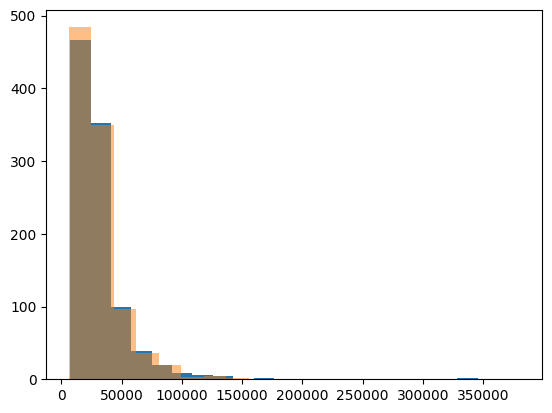

In [10]:
plt.hist(score_males, bins=20)
plt.hist(score_females, bins=20, alpha=0.5)

# GMM Model

In [14]:
amount = 50
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy(), axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy(), axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy(), axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy(), axis=1).T

In [15]:
X_test[y_test=="females"]

,mfcc
3733,"[[-511.90814, -462.6446, -457.9952, -462.46198..."
5708,"[[-401.43353, -423.4886, -426.06964, -424.2950..."
4722,"[[-251.77106, -257.80334, -247.25676, -241.476..."
5769,"[[-406.4093, -409.55896, -392.71524, -383.2830..."
3738,"[[-141.2275, -137.25319, -125.427734, -94.0277..."
...,...
4311,"[[-428.24887, -381.21255, -386.36673, -385.269..."
4648,"[[-172.55688, -215.59618, -225.08438, -211.122..."
5560,"[[-187.09491, -234.17517, -248.84923, -229.425..."
4139,"[[-328.8132, -444.7303, -452.52744, -471.09937..."


In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

gmm_male.fit(X_male)
gmm_female.fit(X_female)

GaussianMixture(max_iter=1000, n_components=12)

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pickle


if not os.path.exists(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):
    
    gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
    gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

    gmm_male.fit(X_male)
    gmm_female.fit(X_female)

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_male,f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_female,f)

else:
    print("File Found")

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_male = pickle.load(f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_female = pickle.load(f)

File Found


/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(array([0.00199958, 0.00133305, 0.00866483, 0.02132882, 0.05132246,
        0.09198052, 0.09731272, 0.09597967, 0.03199322, 0.01199746,
        0.00466568, 0.00066653, 0.00066653, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

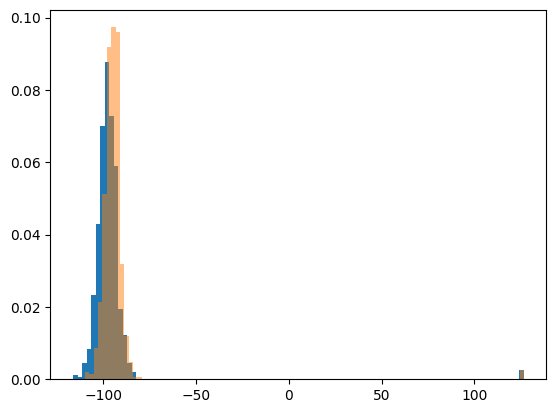

In [17]:
# Lo importante de estos scores es cuanto suman
person = 1
plt.hist(gmm_female.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True)
plt.hist(gmm_male.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True, alpha=0.5)

In [18]:
scores_fgmm = pd.Series(index=y_test.index)
scores_mgmm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fgmm[index] = gmm_female.score_samples(mfcc.T).mean()
    scores_mgmm[index] = gmm_male.score_samples(mfcc.T).mean()

/tmp/ipykernel_27568/3693417576.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fgmm = pd.Series(index=y_test.index)
/tmp/ipykernel_27568/3693417576.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mgmm = pd.Series(index=y_test.index)


In [19]:
display(scores_fgmm[y_test == "males"].mean())
display(scores_fgmm[y_test == "females"].mean())

-96.19078746388192

-95.6244743433806

(array([0.00613184, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00613184, 0.        ,
        0.        , 0.        , 0.00613184, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00613184, 0.00613184,
        0.00613184, 0.        , 0.        , 0.01839552, 0.        ,
        0.00613184, 0.        , 0.01226368, 0.        , 0.00613184,
        0.01839552, 0.00613184, 0.01226368, 0.01839552, 0.02452736,
        0.01226368, 0.        , 0.03065919, 0.02452736, 0.00613184,
        0.01226368, 0.01226368, 0.03679103, 0.03679103, 0.09197758,
        0.07971391, 0.1103731 , 0.09810942, 0.06745023, 0.06131839,
        0.07358207, 0.1103731 , 0.11650494, 0.12876862, 0.14103229,
        0.15329597, 0.17782333, 0.17169149, 0.15329597, 0.20848252,
        0.14716413, 0.20235068, 0.22687804, 0.18395517, 0.21461436,
        0.2207462 , 0.17782333, 0.14716413, 0.06745023, 0.12263678,
        0.09810942, 0.08584574, 0.1103731 , 0.06

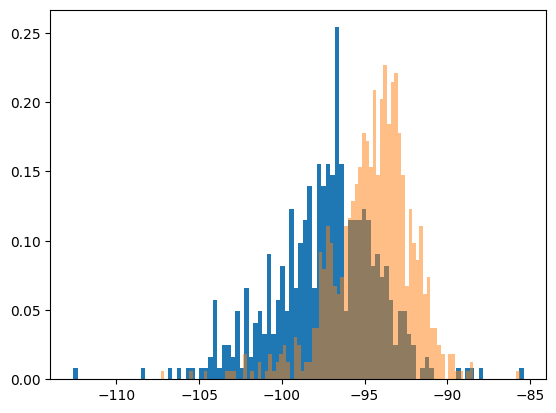

In [20]:
plt.figure()
plt.hist(scores_mgmm[y_test == "females"][:1000], bins=100, density = True)
plt.hist(scores_mgmm[y_test == "males"][:1000], bins=100, density = True, alpha=0.5)


In [21]:
predictions = []
for index in y_test.index:
    if scores_mgmm[index] > scores_fgmm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.91%


# Busqueda de hiperparametros

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(8, 13),
    "covariance_type": ["full", "tied", "diag", "spherical"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(X_male)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
10,8,diag,-33461.914926
11,9,diag,-33442.472437
12,10,diag,-33374.092174
13,11,diag,-33264.468986
5,8,tied,-33140.519868


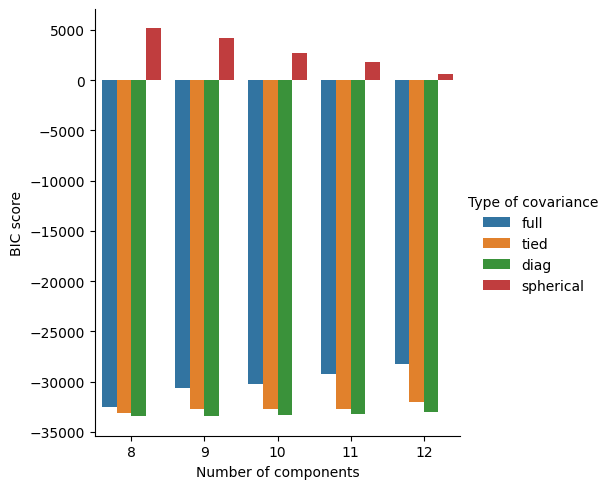

In [ ]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()